# Model hyperparameter tuning
Based on ResNet, I will do some hyperparameter tuning and regularization when needed to achieve better results in my model metrics. I will be also checking for overfitting/underfitting

In [18]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras import models, layers
import tqdm
from PIL import Image

from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, MaxPooling2D, Dropout

import os

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense, Add
from keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Precision, Recall

from keras.models import load_model
from keras.layers import GlobalAveragePooling2D

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, Flatten, Dense, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from keras_tuner import HyperModel
from tensorflow.keras import backend as K
from keras.optimizers import Adam


Setting up Google Drive storage

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
input_shape = (48, 48, 1)  # Shape of input images
num_classes = 7  # Number of classes for classification

### Loading datasets

In [4]:
def read_arrays_from_drive(folder_path, imgs_filename, lbls_filename):
    """
    Reads the imgs and lbls arrays from a Google Drive folder.

    Args:
        folder_path (str): The path to the folder in Google Drive.
        imgs_filename (str): The filename for the imgs array.
        lbls_filename (str): The filename for the lbls array.

    Returns:
        tuple: A tuple containing the imgs and lbls arrays.
    """
    # Load the .npy files from the specified folder in Google Drive
    imgs = np.load(f"{folder_path}/{imgs_filename}")
    lbls = np.load(f"{folder_path}/{lbls_filename}")

    return imgs, lbls

In [5]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/data"
train_imgs_filename = "train_imgs.npy"
train_lbls_filename = "train_lbls.npy"
test_imgs_filename = "test_imgs.npy"
test_lbls_filename = "test_lbls.npy"
val_imgs_filename = "val_imgs.npy"
val_lbls_filename = "val_lbls.npy"

train_imgs, train_lbls = read_arrays_from_drive(folder_path, train_imgs_filename, train_lbls_filename)
test_imgs, test_lbls = read_arrays_from_drive(folder_path, test_imgs_filename, test_lbls_filename)
val_imgs, val_lbls = read_arrays_from_drive(folder_path, val_imgs_filename, val_lbls_filename)

In [6]:
print(f'Shape of training data: {np.shape(train_imgs)}')
print(f'Shape of testing data: {np.shape(test_imgs)}')
print(f'Shape of validation data: {np.shape(val_imgs)}')

Shape of training data: (30709, 48, 48, 1)
Shape of testing data: (3589, 48, 48, 1)
Shape of validation data: (3589, 48, 48, 1)


### Helper functions

In [7]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'auc', 'precision', 'recall']
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric])
        plt.plot(history.history['val_' + metric])
        plt.title('Model ' + metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

### ResNet model architecture

In [ ]:
def residual_block(input_tensor, filters, strides=(1, 1), use_projection=False):
    """
    Creates a residual block for the ResNet architecture.

    Args:
        input_tensor (keras.layers.Layer): The input tensor.
        filters (int): The number of filters for the convolutional layers.
        strides (tuple): The strides for the convolutional layers.
        use_projection (bool): Whether to use projection shortcut.

    Returns:
        keras.layers.Layer: The output tensor of the residual block.
    """
    # Shortcut path
    shortcut = input_tensor

    # First convolutional layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolutional layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)

    # Projection shortcut
    if use_projection:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(input_tensor)
        shortcut = BatchNormalization()(shortcut)

    # Add shortcut to main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

from keras.layers import GlobalAveragePooling2D

def create_resnet_model(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = residual_block(x, filters=64, strides=(1, 1), use_projection=False)
    x = residual_block(x, filters=64, strides=(1, 1), use_projection=False)
    x = residual_block(x, filters=128, strides=(2, 2), use_projection=True)
    x = residual_block(x, filters=128, strides=(1, 1), use_projection=False)
    x = residual_block(x, filters=256, strides=(2, 2), use_projection=True)
    x = residual_block(x, filters=256, strides=(1, 1), use_projection=False)
    
    # Use GlobalAveragePooling2D instead of AveragePooling2D
    x = GlobalAveragePooling2D()(x)

    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)

    return model


Compile the model

In [ ]:
model_resnet = create_resnet_model(input_shape, num_classes)

model_resnet.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# Print the model summary
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 24, 24, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 24, 24, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 24, 24, 64)   0           ['batch_normalization[0][0]']

ResNet baseline consists of trainable 2,780,551 params.

Fitting baseline model

In [ ]:
# Training the model, and validating
base_resnet_history = model_resnet.fit(train_imgs, train_lbls, 
          epochs=10, batch_size=32, 
          validation_data=(val_imgs, val_lbls), verbose=1)

Epoch 1/10
960/960 [==============================] - 39s 19ms/step - loss: 1.9525 - accuracy: 0.4137 - auc: 0.7864 - precision: 0.6769 - recall: 0.2022 - val_loss: 1.9013 - val_accuracy: 0.4001 - val_auc: 0.8017 - val_precision: 0.4955 - val_recall: 0.2622
Epoch 2/10
960/960 [==============================] - 16s 17ms/step - loss: 1.5973 - accuracy: 0.5226 - auc: 0.8616 - precision: 0.7281 - recall: 0.3337 - val_loss: 1.7950 - val_accuracy: 0.4425 - val_auc: 0.8241 - val_precision: 0.5666 - val_recall: 0.3012
Epoch 3/10
960/960 [==============================] - 16s 16ms/step - loss: 1.4319 - accuracy: 0.5721 - auc: 0.8899 - precision: 0.7453 - recall: 0.4026 - val_loss: 1.7994 - val_accuracy: 0.4528 - val_auc: 0.8268 - val_precision: 0.5633 - val_recall: 0.3558
Epoch 4/10
960/960 [==============================] - 16s 17ms/step - loss: 1.3313 - accuracy: 0.6126 - auc: 0.9087 - precision: 0.7602 - recall: 0.4624 - val_loss: 1.5923 - val_accuracy: 0.5272 - val_auc: 0.8587 - val_precisi

Save model

In [ ]:
model_resnet.save('/content/drive/MyDrive/ML Project/data/base_resnet_no_tuning.h5')

Plotting results

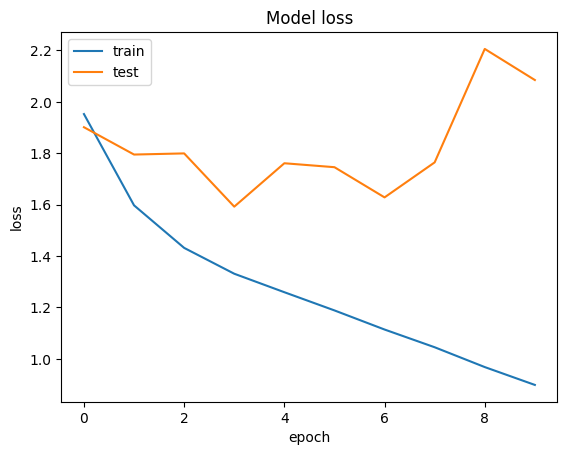

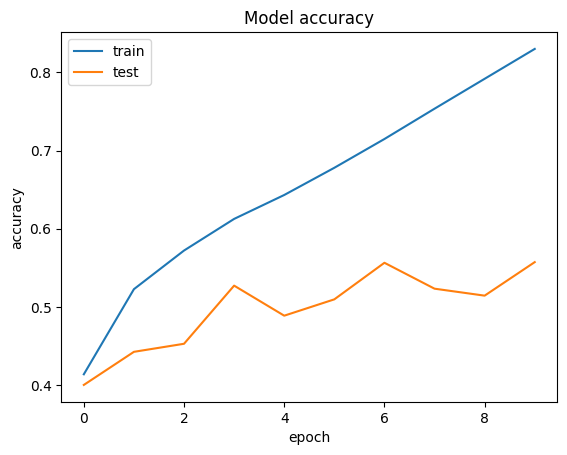

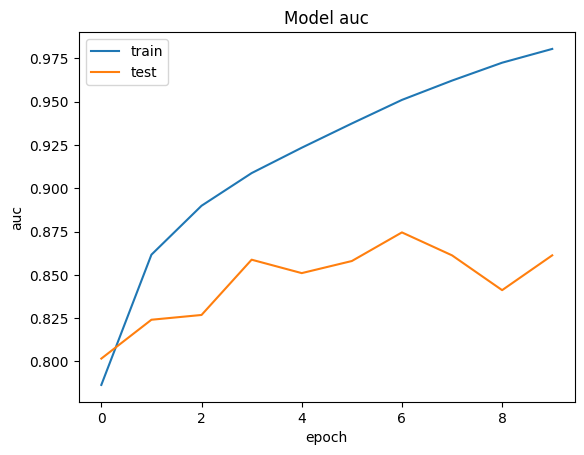

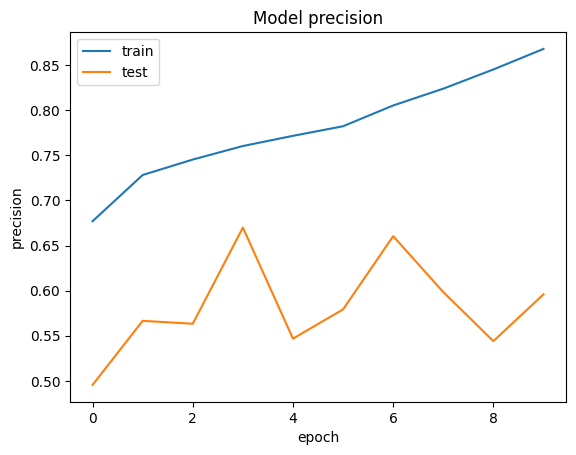

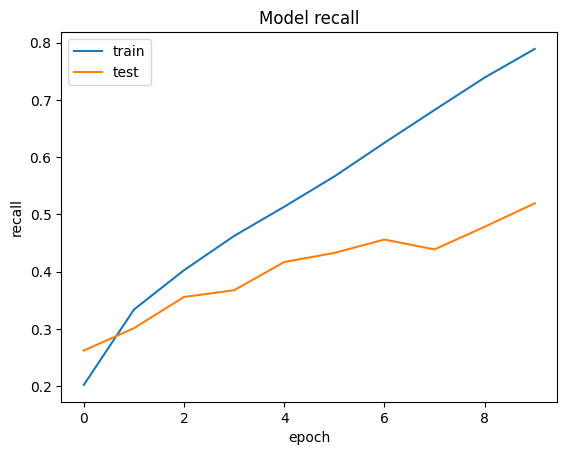

In [ ]:
plot_metrics(base_resnet_history)

## Hyperparameter tuning
For this section, I will use RandomSearch algorithm from the 'kerastuner' package.

In [9]:
#!pip install keras-tuner

In [10]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, Flatten, Dense, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from keras_tuner import HyperModel
from tensorflow.keras import backend as K


def residual_block(input_tensor, filters, strides=(1, 1)):
    # Shortcut path
    shortcut = input_tensor

    # First convolutional layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolutional layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)

    # Use projection shortcut if sizes do not match
    if K.int_shape(x) != K.int_shape(shortcut):
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(input_tensor)
        shortcut = BatchNormalization()(shortcut)

    # Add shortcut to main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x


# ResNet model definition
def create_resnet_model(input_shape, num_classes, filters):
    input_tensor = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = residual_block(x, filters=64, strides=(1, 1))
    x = residual_block(x, filters=64, strides=(1, 1))
    x = residual_block(x, filters=filters, strides=(2, 2))
    x = residual_block(x, filters=filters, strides=(1, 1))
    x = residual_block(x, filters=filters*2, strides=(2, 2))
    x = residual_block(x, filters=filters*2, strides=(1, 1))
    
    # Use GlobalAveragePooling2D instead of AveragePooling2D
    x = GlobalAveragePooling2D()(x)

    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)

    return model


# HyperModel for Keras Tuner
class ResNetHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        filters = hp.Int('filters', min_value=32, max_value=256, step=32)
        model = create_resnet_model(self.input_shape, self.num_classes, filters)

        # Use hyperparameter for learning rate
        lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 0.1])

        model.compile(optimizer=Adam(learning_rate=lr), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy', AUC(name='auc'), Precision(), Recall()])
        
        return model

In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner import Objective

input_shape = (48, 48, 1)
num_classes = 7

hypermodel = ResNetHyperModel(input_shape, num_classes)

tuner = RandomSearch(
    hypermodel,
    objective=Objective('val_auc', direction='max'),
    max_trials=10,
    executions_per_trial=2,
    directory='random_search',
    project_name='emotion_classification'
)

tuner.search(train_imgs, train_lbls,
             epochs=10,
             validation_data=(val_imgs, val_lbls))

Trial 10 Complete [00h 06m 52s]
val_auc: 0.6383393406867981

Best val_auc So Far: 0.8828638195991516
Total elapsed time: 00h 48m 28s


Fiting best model

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_models=1)[0]

TypeError: ignored

In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model
best_model.save('/content/drive/MyDrive/ML Project/data/resnet_with_tuning_auc.h5')

Epoch 1/10
960/960 [==============================] - 16s 14ms/step - loss: 0.9647 - accuracy: 0.7932 - auc: 0.9711 - precision: 0.8443 - recall: 0.7365 - val_loss: 2.3946 - val_accuracy: 0.4829 - val_auc: 0.8122 - val_precision: 0.5294 - val_recall: 0.4461
Epoch 2/10
960/960 [==============================] - 13s 13ms/step - loss: 0.9063 - accuracy: 0.8193 - auc: 0.9784 - precision: 0.8627 - recall: 0.7769 - val_loss: 2.2887 - val_accuracy: 0.4987 - val_auc: 0.8281 - val_precision: 0.5404 - val_recall: 0.4533
Epoch 3/10
960/960 [==============================] - 13s 13ms/step - loss: 0.8450 - accuracy: 0.8522 - auc: 0.9844 - precision: 0.8835 - recall: 0.8202 - val_loss: 2.0757 - val_accuracy: 0.5249 - val_auc: 0.8521 - val_precision: 0.5712 - val_recall: 0.4817
Epoch 4/10
960/960 [==============================] - 13s 14ms/step - loss: 0.8052 - accuracy: 0.8724 - auc: 0.9879 - precision: 0.8979 - recall: 0.8471 - val_loss: 2.2039 - val_accuracy: 0.5311 - val_auc: 0.8467 - val_precisi

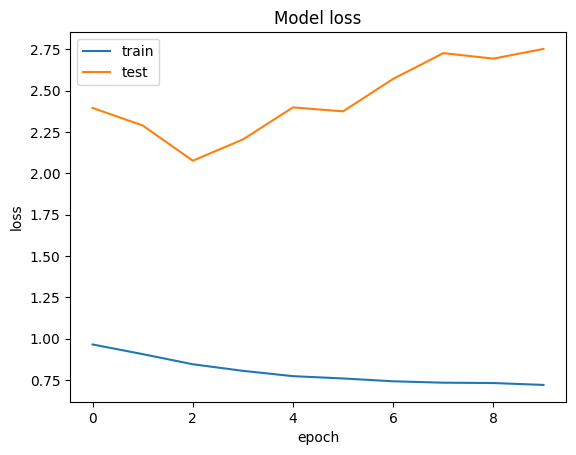

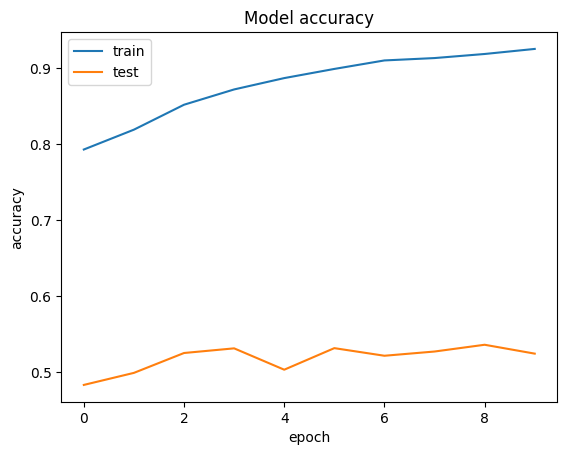

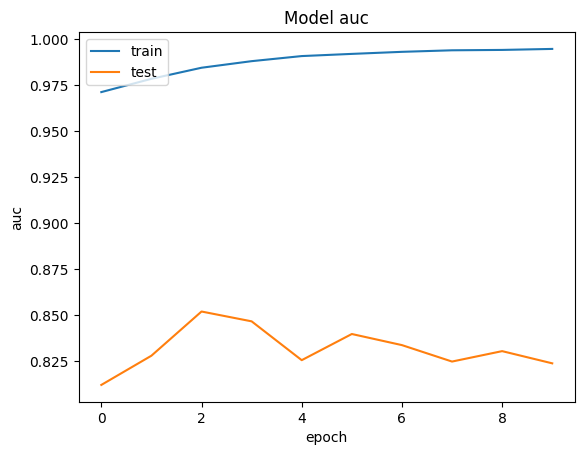

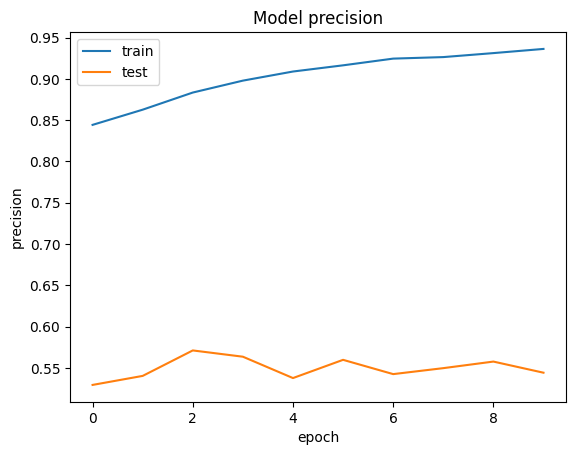

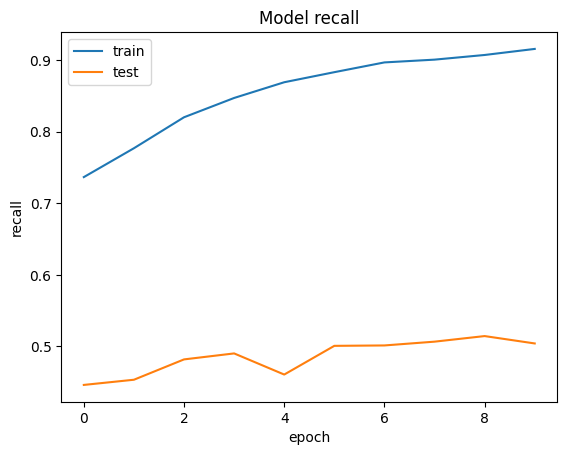

In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Fit the best model
history = best_model.fit(train_imgs, train_lbls, validation_data=(test_imgs, test_lbls), epochs=10)

# Use your helper function to plot the metrics
plot_metrics(history)

### Loading best model

In [11]:

# Specify the path to the h5 model file
model_path = '/content/drive/MyDrive/Colab Notebooks/data/resnet_with_tuning_auc.h5'

# Load the model
loaded_model = load_model(model_path)

Plot metrics for best model

Epoch 1/10
960/960 [==============================] - 25s 14ms/step - loss: 0.9457 - accuracy: 0.7949 - auc: 0.9727 - precision: 0.8485 - recall: 0.7403 - val_loss: 1.7565 - val_accuracy: 0.5634 - val_auc: 0.8729 - val_precision: 0.6202 - val_recall: 0.4951
Epoch 2/10
960/960 [==============================] - 12s 12ms/step - loss: 0.8700 - accuracy: 0.8306 - auc: 0.9805 - precision: 0.8708 - recall: 0.7920 - val_loss: 2.0272 - val_accuracy: 0.5143 - val_auc: 0.8475 - val_precision: 0.5646 - val_recall: 0.4675
Epoch 3/10
960/960 [==============================] - 12s 13ms/step - loss: 0.8243 - accuracy: 0.8572 - auc: 0.9851 - precision: 0.8879 - recall: 0.8285 - val_loss: 1.9675 - val_accuracy: 0.5508 - val_auc: 0.8649 - val_precision: 0.5939 - val_recall: 0.5110
Epoch 4/10
960/960 [==============================] - 12s 13ms/step - loss: 0.7953 - accuracy: 0.8725 - auc: 0.9880 - precision: 0.8977 - recall: 0.8495 - val_loss: 2.3843 - val_accuracy: 0.5029 - val_auc: 0.8247 - val_precisi

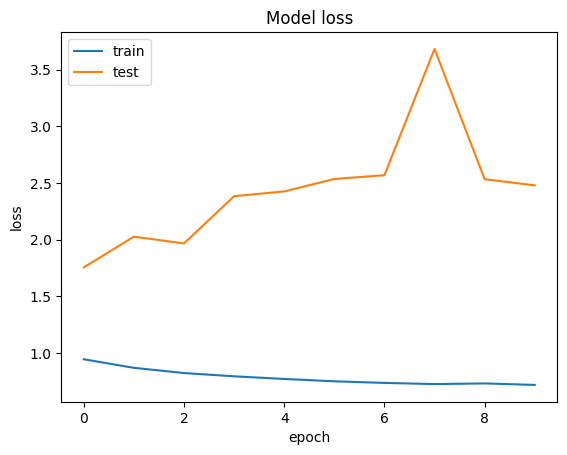

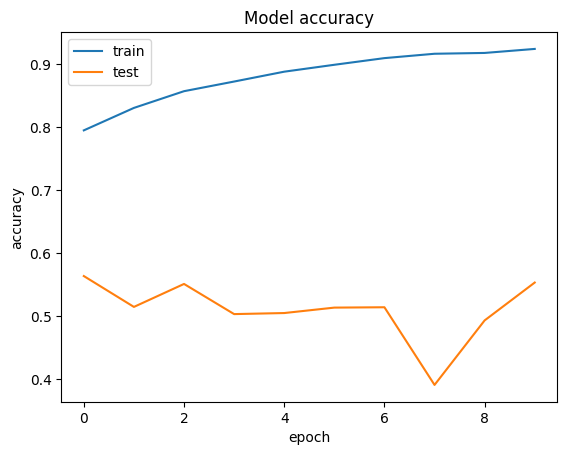

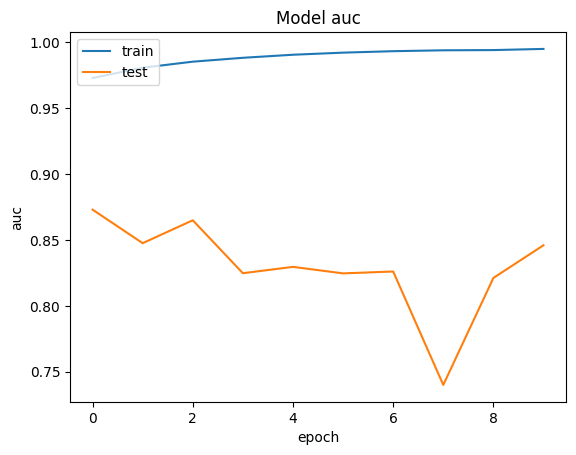

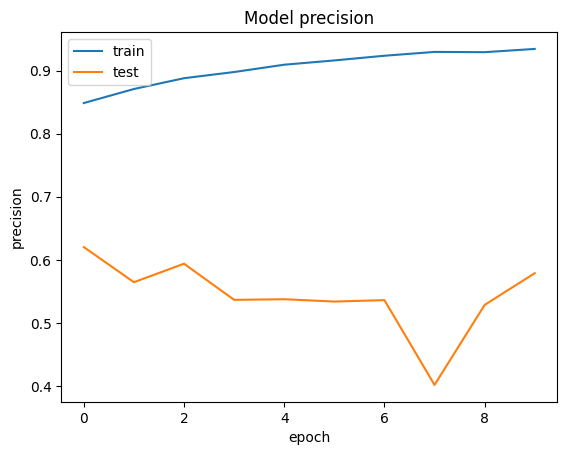

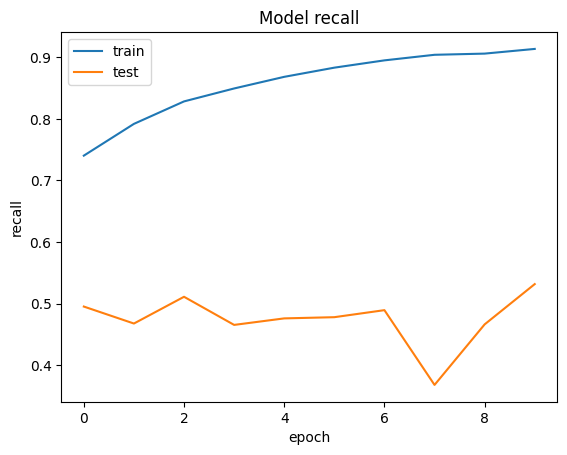

In [12]:
# Fit the best model
history = loaded_model.fit(train_imgs, train_lbls, validation_data=(val_imgs, val_lbls), epochs=10)

# Use your helper function to plot the metrics
plot_metrics(history)

## Hyperparameter tuning with early stopping as regularization

In [19]:
from keras.callbacks import EarlyStopping
from kerastuner import Objective
from kerastuner import RandomSearch

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

input_shape = (48, 48, 1)
num_classes = 7

hypermodel_early = ResNetHyperModel(input_shape, num_classes)

tuner_early = RandomSearch(
    hypermodel_early,
    objective=Objective('val_auc', direction='max'),
    max_trials=10,
    executions_per_trial=2,
    directory='random_search',
    project_name='emotion_classification'
)

tuner_early.search(train_imgs, train_lbls,
             epochs=10,
             validation_data=(val_imgs, val_lbls),
             callbacks=[early_stopping])  # Pass the EarlyStopping callback here


Trial 10 Complete [00h 05m 56s]
val_auc: 0.637480229139328

Best val_auc So Far: 0.8736943900585175
Total elapsed time: 00h 51m 07s


In [20]:
# Get the best model
best_model_early = tuner_early.get_best_models(num_models=1)[0]

# Save the best model
best_model_early.save('/content/drive/MyDrive/Colab Notebooks/data/resnet_with_tuning_auc_early.h5')

Epoch 1/10
960/960 [==============================] - 15s 13ms/step - loss: 0.9873 - accuracy: 0.7112 - auc: 0.9501 - precision: 0.8015 - recall: 0.6192 - val_loss: 1.6172 - val_accuracy: 0.5110 - val_auc: 0.8547 - val_precision: 0.6001 - val_recall: 0.4227
Epoch 2/10
960/960 [==============================] - 12s 13ms/step - loss: 0.9330 - accuracy: 0.7392 - auc: 0.9579 - precision: 0.8152 - recall: 0.6589 - val_loss: 1.5726 - val_accuracy: 0.5514 - val_auc: 0.8701 - val_precision: 0.6263 - val_recall: 0.4678
Epoch 3/10
960/960 [==============================] - 13s 13ms/step - loss: 0.8914 - accuracy: 0.7604 - auc: 0.9638 - precision: 0.8300 - recall: 0.6907 - val_loss: 1.8238 - val_accuracy: 0.4987 - val_auc: 0.8438 - val_precision: 0.5487 - val_recall: 0.4377
Epoch 4/10
960/960 [==============================] - 12s 13ms/step - loss: 0.8537 - accuracy: 0.7771 - auc: 0.9688 - precision: 0.8348 - recall: 0.7136 - val_loss: 1.7101 - val_accuracy: 0.5352 - val_auc: 0.8595 - val_precisi

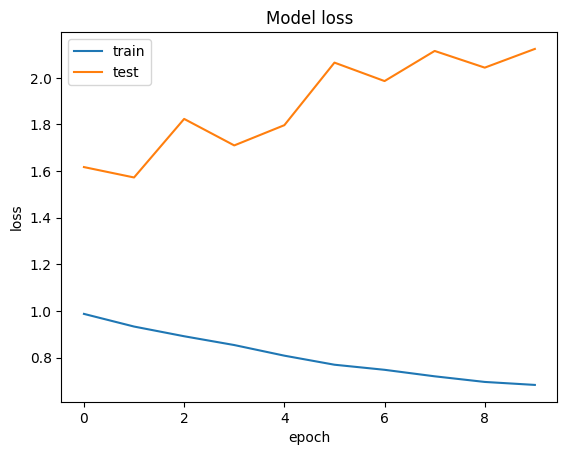

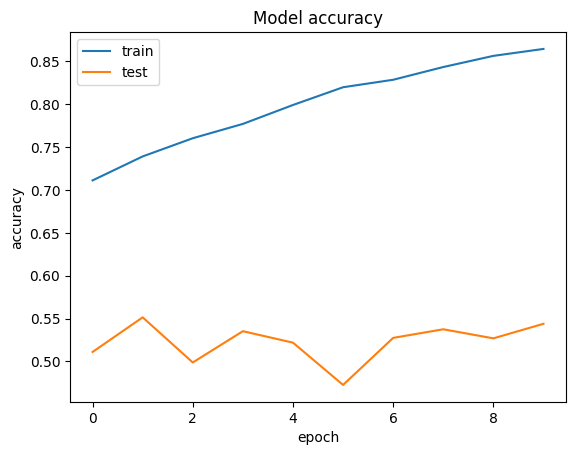

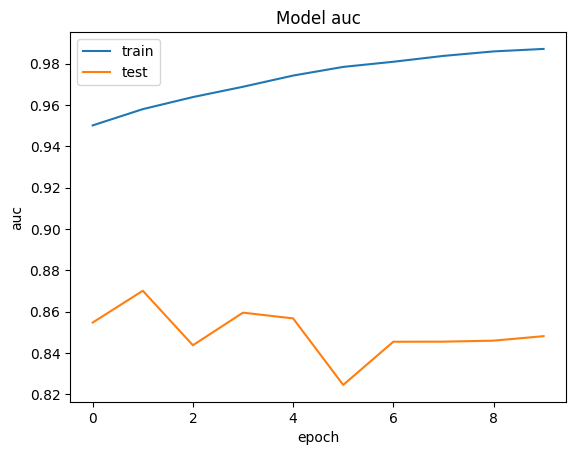

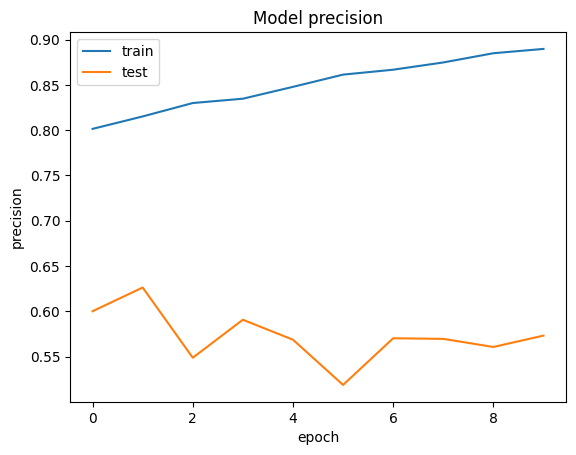

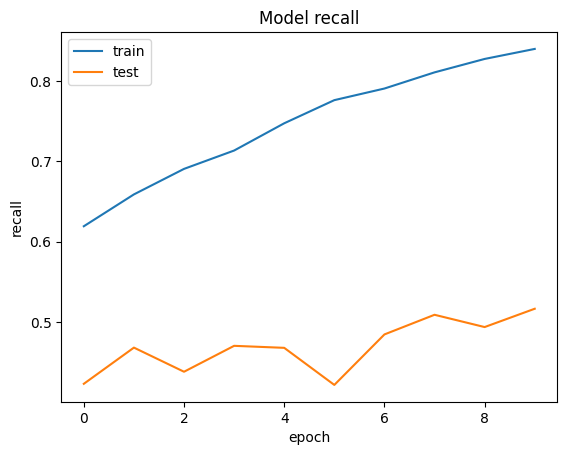

In [21]:
# Fit the best model
history_early = best_model_early.fit(train_imgs, train_lbls, validation_data=(val_imgs, val_lbls), epochs=10)

# Use your helper function to plot the metrics
plot_metrics(history_early)

## Model performance

Confusion matrix

113/113 [==============================] - 3s 10ms/step


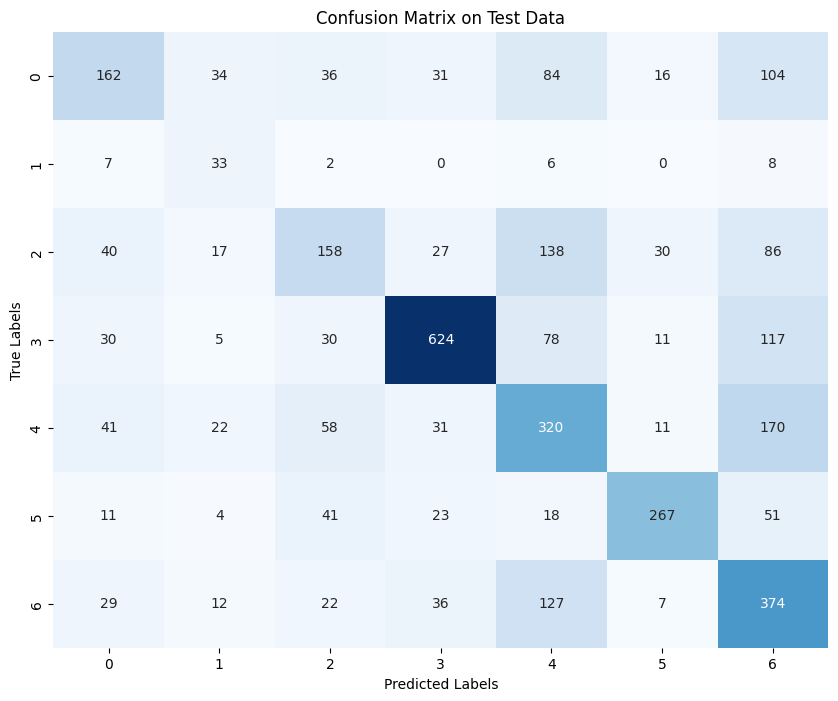

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions on the test set
predictions = best_model_early.predict(test_imgs)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(test_lbls, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix on Test Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Classification report

In [23]:
from sklearn.metrics import classification_report

# Make predictions on the test set using the best model
predictions = best_model_early.predict(test_imgs)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(test_lbls, axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)

113/113 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.51      0.35      0.41       467
           1       0.26      0.59      0.36        56
           2       0.46      0.32      0.37       496
           3       0.81      0.70      0.75       895
           4       0.42      0.49      0.45       653
           5       0.78      0.64      0.71       415
           6       0.41      0.62      0.49       607

    accuracy                           0.54      3589
   macro avg       0.52      0.53      0.51      3589
weighted avg       0.57      0.54      0.54      3589



## Visualizing model performance

113/113 [==============================] - 1s 8ms/step


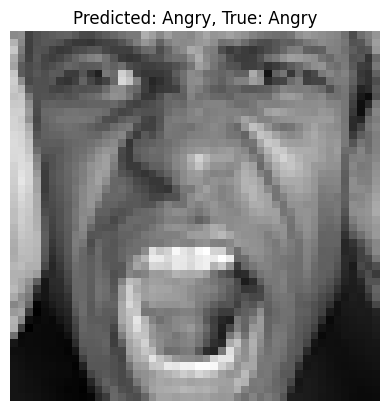

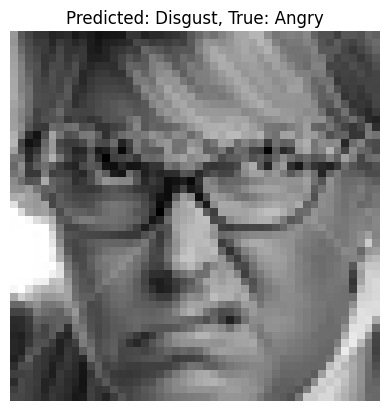

In [30]:
# Assuming you have this mapping
class_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

def plot_image(image, predicted_label, true_label):
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title("Predicted: " + class_names[predicted_label] + ", True: " + class_names[np.argmax(true_label)])
    plt.axis('off')
    plt.show()


# Get predictions for validation data
predictions = best_model_early.predict(val_imgs)
predicted_classes = np.argmax(predictions, axis=1)

correct_indices = np.where(predicted_classes == np.argmax(val_lbls, axis=1))[0]
incorrect_indices = np.where(predicted_classes != np.argmax(val_lbls, axis=1))[0]

if len(correct_indices) > 0:
    i = correct_indices[0]
    plot_image(val_imgs[i], predicted_classes[i], val_lbls[i])

if len(incorrect_indices) > 0:
    i = incorrect_indices[0]
    plot_image(val_imgs[i], predicted_classes[i], val_lbls[i])